In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version: ', tf.__version__)
print('TFP version: ', tfp.__version__)

TF version:  2.4.1
TFP version:  0.12.1


# The DistributionLambda layer

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create a probabilitistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$y = \text{sigmoid(x)} = \frac{1}{1+\text{exp}(-x)}$$

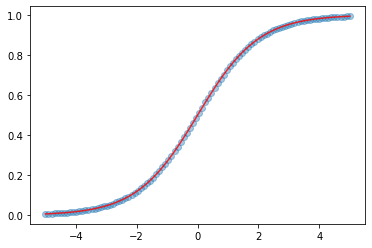

In [55]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
         kernel_initializer=tf.constant_initializer(1),
         bias_initializer=tf.constant_initializer(0))
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1+np.exp(-x_plot)), color='r', alpha=0.8);

In [7]:
# Create a constant input for this model

x = np.array([[0]])
x

array([[0]])

In [8]:
# Explore the feedforward object...

y_model = model(x)
y_model

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5]], dtype=float32)>

In [9]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x))

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


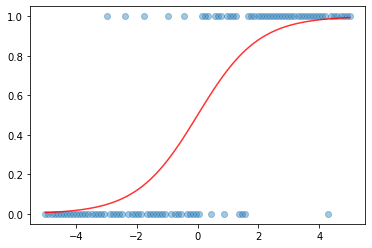

In [28]:
# Create a sigmoid probabilistic model with a Bernoulli distribution

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
         kernel_initializer=tf.constant_initializer(1),
         bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1+np.exp(-x_plot)), color='r', alpha=0.8);

In [29]:
# Create a constant input for this model

x = np.array([[0]])
x

array([[0]])

In [30]:
# Explore the feedforward object...

y_model = model(x)
y_model

<tfp.distributions.Bernoulli 'sequential_5_distribution_lambda_2_Bernoulli' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [31]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x))

[[1]]
[[0]]
[[1]]
[[1]]
[[0]]


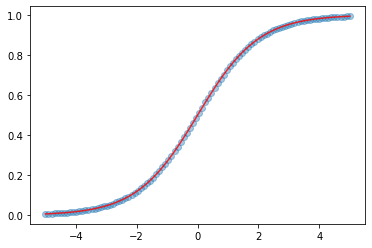

In [14]:
# We can also specify the output to be the mean value instead of the sample from the distribution
# Create a sigmoid probabilistic model with a Bernoulli distribution

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
         kernel_initializer=tf.constant_initializer(1),
         bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.mean)
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1+np.exp(-x_plot)), color='r', alpha=0.8);

In [15]:
# Create a constant input for this model

x = np.array([[0]])
x

array([[0]])

In [16]:
# Explore the feedforward object...

y_model = model(x)
y_model

<tfp.distributions.Bernoulli 'sequential_4_distribution_lambda_1_Bernoulli' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [17]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x))

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


#### Use the forward model to create probabilitistic training data

In [104]:
# Create a sigmoid probabilistic model with a Bernoulli distribution

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
         kernel_initializer=tf.constant_initializer(1),
         bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

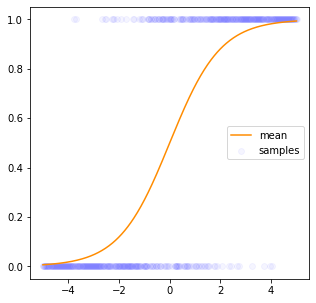

In [105]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), color='darkorange', label='mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

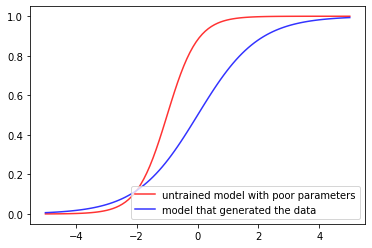

In [106]:
# Create a new version of the model, with the wrong weights

model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
         kernel_initializer=tf.constant_initializer(2),
         bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
                           convert_to_tensor_fn=tfd.Distribution.sample)
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.plot(x_plot, 1/(1+np.exp(-(2*x_plot+2))), color='r', alpha=0.8, label='untrained model with poor parameters')
plt.plot(x_plot, 1/(1+np.exp(-x_plot)), color='b', alpha=0.8, label='model that generated the data')
plt.legend();

#### Train the new model with the negative loglikelihood

In [107]:
# Define negative loglikelihood, which we will use for training

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [108]:
# Compile untrained model

model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))

In [109]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0,0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0,0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

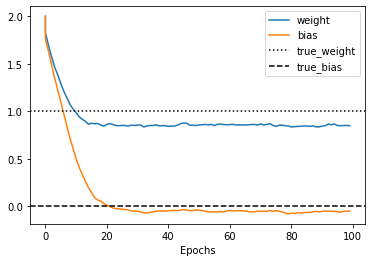

In [110]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()